In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 5070 Ti


In [ ]:

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)


    def forward(self, x):

        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:

class Inception(nn.Module):


    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
 
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)


        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, dim=1)

In [ ]:

class GoogLeNet(nn.Module):

    def __init__(self, num_classes=1000):
        super().__init__()

        self.part1 = nn.Sequential(
            BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        self.part2 = nn.Sequential(
            BasicConv2d(64, 64, kernel_size=1),
            BasicConv2d(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )
    
        self.part3 = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        self.part4 = nn.Sequential(
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        self.part5 = nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
            nn.AdaptiveAvgPool2d((1, 1))
        )
   
        self.part6 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )


    def forward(self, x):
     
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        x = self.part4(x)
        x = self.part5(x)
        x = self.part6(x)
        return x

In [ ]:

summary(GoogLeNet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
GoogLeNet                                     [1, 1000]                 --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─BasicConv2d: 2-1                       [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-2                         [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 192, 28, 28]          --
│    └─BasicConv2d: 2-3                       [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-3                       [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-4                  [1, 64, 56, 56]           128
│    └─BasicConv2d: 2-4                       [1, 192, 56, 56]          --
│    │    └─Conv2d: 3-5                       [1, 192, 56, 56]          110,592
│    │ 

Epoch: 0 Loss: 2.606550258712708 Acc: 0.07647058823529412
Epoch: 10 Loss: 2.2719235061702605 Acc: 0.38529411764705884
Epoch: 20 Loss: 2.113309156169679 Acc: 0.503921568627451
Epoch: 30 Loss: 2.0002769345172147 Acc: 0.5607843137254902
Epoch: 40 Loss: 1.8917559270071314 Acc: 0.6284313725490196
Epoch: 50 Loss: 1.837034224634421 Acc: 0.6411764705882353
Epoch: 60 Loss: 1.7292830929304028 Acc: 0.7029411764705882
Epoch: 70 Loss: 1.6826403345383152 Acc: 0.6686274509803921
Epoch: 80 Loss: 1.623576323194288 Acc: 0.7313725490196078
Epoch: 90 Loss: 1.5993960799703835 Acc: 0.7303921568627451
Epoch: 100 Loss: 1.5356736884130129 Acc: 0.753921568627451
Epoch: 110 Loss: 1.4935409312449326 Acc: 0.746078431372549
Epoch: 120 Loss: 1.5292323486531025 Acc: 0.7372549019607844
Epoch: 130 Loss: 1.4449281253052257 Acc: 0.7617647058823529
Epoch: 140 Loss: 1.4462733162507222 Acc: 0.7480392156862745
Epoch: 150 Loss: 1.3743899494610434 Acc: 0.765686274509804
Epoch: 160 Loss: 1.3530779661717445 Acc: 0.75392156862745

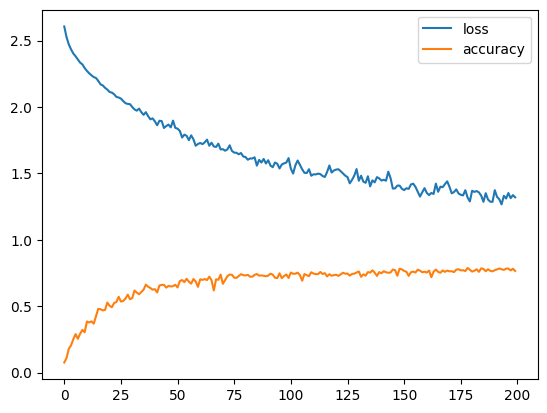

Accuracy: 0.765686274509804


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(0)


model = GoogLeNet(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()


trainform_train = transforms.Compose([
    transforms.RandomRotation(30), 
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5), 
    transforms.ToTensor(), 
   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

num_epochs = 200 
loss_history = []  
acc_history = []  


for epoch in tqdm(range(num_epochs), file=sys.stdout):
  
    total_loss = 0
    total_correct = 0
    

    model.train()
    for inputs, labels in train_loader:
  
        inputs = inputs.to(device)
        labels = labels.to(device)
        

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
 
        total_loss += loss.item()
    

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)

            total_correct += (outputs.argmax(1) == labels).sum().item()
        

    loss_history.append(np.log10(total_loss))  
    acc_history.append(total_correct / len(test_dataset))
    

    if epoch % 10 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))


import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()


print("Accuracy:", acc_history[-1])